In [1]:
# Initialisation(s)

import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/nonogram/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

sys.path.append(f'{global_prefix}../outils')
import displayImages

import os
import json
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['toolbar'] = 'None'

# [Nonograms](https://en.wikipedia.org/wiki/Nonogram)

Il s'agit ici de résoudre des nonograms *faciles* (à préciser) et de fournir la suite des opérations qui ont mené à cette résolution.

### Utilisation

Un nonogram est représenté par une instance *n* de la classe $\texttt{NONOGRAM}$ :

*n*$\texttt{ = NONOGRAM(}$*lines*$\texttt{, } $*cols*$\texttt{, colors = None, name = None, solution = None)}$

- *lines* (*cols*) est la suite des indications pour les lignes (colonnes) ; c'est une liste de listes d'entiers si le nonogram est noir et blanc et, s'il est couleur, c'est 
une  liste de listes de couples d'entiers, le deuxième entier de chaque couple désignant le code d'une couleur.
- Dans le cas couleur, $\texttt{colors}$ est le dictionnaire des associations *code* $\texttt{:}$ *couleur*.   
Ce dictionnaire doit contenir au moins l'association 
$\texttt{0 : '\#FFFFFF'}$ ; les autres couleurs ont pour codes les entiers $\texttt{1}$, $\texttt{2}$, $\ldots$ et sont données 
en hexadécimal $\texttt{'\#}$*xxxxxx*$\texttt{'}$.  
S'il y a un risque que le programme ne parvienne pas à déterminer tous les pixels de *n*, il faut aussi définir une couleur de code $\texttt{-1}$ pour remplir les pixels non calculés.
- $\texttt{name}=$ *name* une chaîne de caractères  non vide.
- Si l'on connait à l'avance la solution de *n*, il y a des avantages à la fournir sous la forme $\texttt{solution = }$ liste de listes d'entiers ($\texttt{1}$ et 
$\texttt{0}$ si noir et blanc, codes couleurs sinon). Mais cela n'aidera pas la résolution.

La méthode principale de la classe est $\texttt{solve}$ :

Si tout se passe bien, *n*$\texttt{.solve()}$ calcule et affiche la solution et stocke dans le répertoire $\texttt{images}$ des fichiers *name*$\texttt{-0.png}$, *name*$\texttt{-1.png}$, etc., qui expliquent la résolution (une flèche horizontale ou verticale en haut à gauche de la grille indique que les pixels nouvellement calculés, indiqués par un point rouge, l'ont été en considérant les lignes ou les colonnes).   
Sinon, les fichiers *name*$\texttt{-}i\texttt{.png}$ contiennent les explications pour les pixels que le programme a réussi à calculer. Cela n'a d'intérêt que s'il reste peu de pixels non calculés.

### Algorithme

##### Structure de l'algorithme

1. Pour chaque ligne $L$, calculer les pixels de $L$ que l'on peut déduire des indications de $L$.  
2. Pour chaque colonne $C$, calculer les pixels de $C$ que l'on peut déduire des indications de $C$ et des pixels calculés à l'étape 1.
3. Pour chaque ligne $L$ qui contient un pixel calculé à l'étape précédente, calculer les pixels de $L$ que l'on peut déduire des indications de $L$ et des pixels de $L$ déja calculés.  
4. Pour chaque colonne $C$ qui contient un pixel calculé à l'étape précédente, calculer les pixels de $C$ que l'on peut déduire des indications de $C$ et des pixels de $C$ déja calculés. 
5. Si les deux étapes précédentes n'ont donné lieu à aucun nouveau pixel calculé (il reste donc des pixels non calculés) ou si tous les pixels ont été calculés, arrêter.  
   Sinon, retourner à l'étape 3.

Le nonogram sera dit *facile* si l'algorithme précédent calcule tous ses pixels.

Précisons la manière de calculer les pixels d'une ligne ou d'une colonne donnée à chaque étape. On notera que le procédé est simple mais qu'il peut être très gourmand, à la fois en mémoire et en temps, ce qui rend l'algorithme inefficient pour les grands nonograms $\ldots$

##### Initialisation

Soient $m$ et $n$ les nombres de lignes et de colonnes de *n*.  
Une *valeur de ligne* est une liste de $n$ entiers qui définit les couleurs des éléments d'une ligne, idem pour la notion de *valeur de colonne*. 

On introduit deux listes de listes de listes d'entiers *lignes_possibles* et *colonnes_possibles*.   

Initialement, pour tout $i\in[0,n-1]$, on affecte à *lignes_possibles*$[i]$ la liste, dans un ordre arbitraire, des valeurs de ligne compatibles avec les indications de la ligne $i$.  
Pour cela, en supposant le cas noir et blanc pour fixer les idées, soient $\iota_0,\ldots,\iota_{p-1}$ les indices de la ligne $i$.  
Si $s=\iota_0+\ldots+\iota_{p-1}$, $n-s$  est le nombre de cases qui seront vides ($=0$) dans cette ligne.  
A toute partition $(t_0,\ldots,t_p)\in\mathbf N^{p+1}$ de $k=n-s-(p-1)$ en $p+1$ termes $(k = t_0+\ldots+t_p)$, on associe
la ligne   
$0\;(t_0\;\text{fois}), 1\;(\iota_0\;\text{fois}),0\;(t_1+1\;\text{fois}), 1\;(\iota_1\;\text{fois}),\ldots,1\;(\iota_{p-1}\;\text{fois}),0\;(t_p\;\text{fois})$   
et on obtient ainsi toutes les lignes possibles.

Idem pour les colonnes possibles.

##### Calculs des pixels

Précisons le traitement d'une ligne $i$ à une étape 1 ou 3 :  

Pour chaque colonne $j$ pour laquelle on ne connait pas la valeur du pixel $i,j$, on teste si les *lignes_possibles*$[i][k][j]$ ont la même valeur $v$ pour tous les $k$. Dans ce cas, on affecte au pixel $i,j$ la valeur $v$ et on supprime de
*colonnes_possibles*$[j]$ les valeurs de colonne dont le $i$-ième élément est
différent de $v$.

Idem pour le traitement d'une colonne $j$ à une étape 2 ou 4.

### Implémentation

Tout d'abord, l'initialisation de *lignes_possibles* et *colonnes_possibles*, nécessite l'écriture d'une
fonction $\texttt{partitions(}n\texttt{,}k\texttt{)}$ qui génère les partitions de l'entier $n$ en $k$ termes, soit les éléments de 
l'ensemble $E_{n,k}=\{t=(t_0,\ldots,t_{k-1})\in\mathbf N^k\,|\,n = t_0+\ldots+t_{k-1}\}$  

Pour cela, posons $m=n+k-1$ et $h =k-1$ et introduisons l'ensemble $F_{m,h}=\{c=(c_1,\ldots,c_{h})\in\mathbf N^h\,|\,-1<c_1<\ldots<c_h<m\}$ des
$h$-combinaisons de $[0,m-1]$.   
Pour un élément $c=(c_1,\ldots,c_{h})$ de $F_{m,h}$, on convient de poser $c_0=-1$ et $c_{h+1}=m$.  

On vérifie alors facilement que l'application $c\mapsto t=(c_{i+1}-c_i-1)_{i=0,\ldots,k-1}$ est une bijection de  $F_{m,h}$ sur $E_{n,k}$

Or l'expression python $\texttt{itertools.combinations(range(}m\texttt{),}h\texttt{)}$ renvoie un itérateur qui génère 
les $h$-combinaisons de $[0,m-1]$.

D'où la fonction suivante.

In [2]:
def partitions(n,k):
    m = n + k - 1
    for c in itertools.combinations(range(m), k - 1):
        d = (-1,) + c + (m,)
        yield tuple(d[i + 1] - d[i] - 1 for i in range(k))

Quant au reste de l'implémentation de la méthode $\texttt{solve}$, voir le source.

### Autres fonctionalités

On dispose aussi de :
- *n*$\texttt{.m}$ nombre $m$ de lignes
- *n*$\texttt{.n}$ nombre $n$ de colonnes
- *n*$\texttt{.size()}$ $(n,m)$
- *n*$\texttt{.colored}$ booléen
- *n*$\texttt{.lines}$ donné lors de la définition de *n*
- *n*$\texttt{.cols}$ donné lors de la définition de *n*
- *n*$\texttt{.name}$ donné lors de la définition de *n*
- *n*$\texttt{.colors}$ donné éventuellement lors de la définition de *n*
- *n*$\texttt{.solution}$ donné lors de la définition de *n* ou calculé par *n*$\texttt{.solve()}$ ou $\texttt{None}$
- *n*$\texttt{.plotBoard()}$ affiche la grille, sans la solution
- *n*$\texttt{.plot()}$ affiche la solution, sans la grille (si *n*$\texttt{.solution}$ n'est pas $\texttt{None}$) 
- *n*$\texttt{.print()}$ imprime la solution au format texte, sans la grille et sans tenir compte des couleurs (si *n*$\texttt{.solution}$ n'est pas $\texttt{None}$)
- *n*$\texttt{.save()}$ sauvegarde *n* dans le fichier $\texttt{exemples/}$*rep*$\texttt{/}$*name*$\texttt{.json}$ où *rep* $=\texttt{noiretblanc}$ ou  $\texttt{couleur}$ selon le cas, et *name* $=$ *n*$\texttt{.name}$
- *n* $=\texttt{NONOGRAM.load(}$*name*$\texttt{)}$ permet de retrouver un nonogram préalablement sauvegardé

Les nonograms sauvegardés dans les répertoires $\texttt{exemples/noiretblanc}$ et $\texttt{exemples/couleur}$ sont tous issus du site 
[nonograms.org](https://www.nonograms.org).   
Ils sont tous *faciles* sauf ceux dont le nom commence par $\texttt{notAllPixels}$ (pour lesquels il manque un petit nombre de pixels).   

In [55]:
class NONOGRAM:
 
    def __init__(self, lines, cols, colors = None, name = None, solution = None, idNonogramsOrg = None):
        
        self.m = len(lines)
        self.n = len(cols)
        self._p = max(len(clues) for clues in lines)
        self._q = max(len(clues) for clues in cols)
        self.colored = type(lines[0][0]) is tuple
        self.lines = lines
        self.cols = cols
        self.colors = {-1 : '#0000FF', 0 : '#FFFFFF', 1 : '#000000'} if colors is None else colors
        self.name = 'untitled' if name is None else name
        self.solution = solution
        self._solution = None if solution is None else np.array(solution, dtype=np.int8)
        self.idNonogramsOrg = idNonogramsOrg # identificateur du nonogram si celui-ci provient de https://www.nonograms.org/ (voir plus loin)
        self._count = self.n * self.m # nombre de pixels restant à calculer
        self._countImages = -1 # nombre d'images stockées sur disque - 1
        self._grid = np.zeros(shape = (self.m,self.n), dtype = np.int8) - 1 # -1 = inconnu; 0 = vide; 1 = noir (si noir et blanc), c (> 0) = couleur
        self._ok = False # non encore résolu
        self._begin = True # sera mis à False après les étapes 1 et 2 de l'algorithme
        self._squaresToDraw = [] # pixels calculés à une étape ; utile pour limiter les calculs à l'étape suivante
    
    def solve(self):

        # stockage sur disque de la figure courante
        def saveFig():
            self._countImages += 1
            plt.savefig(f'images/{self.name}-{self._countImages}.png')
        
        self._ok = True

        # Initialisation des lignes et des colonnes possibles
        self._possibleLines = self._generatePossibilities(self.lines, self.n)
        self._possibleCols = self._generatePossibilities(self.cols, self.m)

        # Initialisation de la figure matplotlib
        fig = plt.figure(facecolor='w', figsize = ((self.n + self._p) * .3, (self.m + self._q) * .3), frameon = True)
        self._ax = fig.add_subplot(111)

        # Dessin de la grille
        self._drawBoard(self._ax)
        saveFig()

        # tant qu'il reste des pixels à calculer
        while self._count:
            count = self._count
            # étape 1 ou 3 de l'algorithme selon la valeur de self._begin
            self._induceSquares(self._possibleLines, True)
            saveFig()
            # étape 2 ou 4 de l'algorithme selon la valeur de self._begin
            self._induceSquares(self._possibleCols, False)
            saveFig()
            self._begin = False
            if count == self._count:
                # il reste des pixels non calculables par le programme
                self._ok = False
                break
        for i, j in self._squaresToDraw :
            self._drawSquare(i,j)

        self._drawSolution(self._grid)
        saveFig()

        if self._solution is not None and not self._ok:
            self._drawSolution(self._solution)
            saveFig()

        if self._solution is None and self._ok:
            self._solution = self._grid
            self.solution = [[x for x in l] for l in self._grid]

    def _generatePossibilities(self, cluesList, length):
        possibilitiesList = []
        for clues in cluesList:
            p = len(clues) # nombre d'indices
            if p:
                s = sum([t[0] for t in clues] if self.colored else clues) # nombre de cases non vides
                if self.colored:
                    doubles = [i for i in range(p - 1) if clues[i][1] == clues[i + 1][1]]
                    k = length - s - len(doubles) # nombre de cases vides à définir
                    possibles = []
                    for t in partitions(k, p + 1):
                        possibility = [0] * t[0]
                        for i in range(p):
                            possibility += [clues[i][1]] * clues[i][0] + ([0] if i in doubles else [])
                            possibility += [0] * t[i + 1]
                        possibles.append(tuple(possibility))
                else:
                    k = length - s - p + 1 # nombre de cases vides à définir
                    possibles = []
                    for t in partitions(k, p + 1):
                        possibility = [0] * t[0]
                        for i in range(p):
                            possibility += [1] * clues[i] + ([0] if i < p - 1 else [])
                            possibility += [0] * t[i + 1]
                        possibles.append(tuple(possibility))
            else:
                possibles = [(0,) * length]
            possibilitiesList.append(possibles)
        return possibilitiesList
    
    def _drawArrow(self,direction, color):
        e = .1
        options = {'length_includes_head' : True, 'width' : .4 if color == 'white' else .1, 'color' : color}
        if direction == 'h':
            self._ax.arrow(-self._p + e, self.m + .5 * self._q, self._p - 2. * e, 0., **options)
        else:
            self._ax.arrow(-self._p * .5, self.m + self._q -  e, 0., -self._q + 2. * e, **options)
                         
    def _drawSquare(self,i,j, hint = False):
        v = self._grid[i,j]
        if v:
            if hint:
                self._ax.add_patch(plt.Rectangle((j ,self.m - i - 1.), 1 , 1, fill = True, fc = self.colors[v]))
                self._ax.plot(j + .5 ,self.m - i - .5, marker = 'o', markersize = 2, color = 'white' if self.colors[v].lower() == '#ff0000' else 'red')
            else:
                self._ax.plot(j + .5 ,self.m - i - .5, marker = 'o', markersize = 3, 
                             color = self.colors[0] if v < 0 else self.colors[v])
        else:
            self._ax.plot(j + .5 ,self.m - i - .5, marker = 'o', markersize = 2, color = 'red' if hint else 'black')

    def _induceSquares(self,possibilitiesList, areLines):
        for i, j in self._squaresToDraw :
            self._drawSquare(i,j)
        self._drawArrow('v' if areLines else 'h', 'white')
        self._drawArrow('h' if areLines else 'v', 'black')
        if self._begin:
            indexesToSee = list(range(len(possibilitiesList)))
        else:
            indexesToSee = {i if areLines else j for i,j in self._squaresToDraw}
        self._squaresToDraw = []
        for i in indexesToSee:
            possibles = possibilitiesList[i]
            if possibles:
                for j in range(len(possibles[0])):
                    if (self._grid[i,j] if areLines else self._grid[j,i]) < 0:
                        v = possibles[0][j]
                        if all([v == possibles[k][j] for k in range(len(possibles))]):
                            self._count -= 1
                            ii, jj = (i, j) if  areLines else (j, i)
                            self._squaresToDraw.append((ii,jj))
                            self._grid[ii,jj] = v
                            self._drawSquare(ii, jj, True)
                            if areLines:
                                self._possibleCols[j] = [p for p in self._possibleCols[j] if p[i] == v]
                            else:
                                self._possibleLines[j] = [p for p in self._possibleLines[j] if p[i] == v]

    def _drawBoard(self, ax):

        def bw(color): # color de la forme '#XXXXXX'
            return 'white' if sum(int(color[i:i+2], 16) for i in (1, 3, 5)) < 382 else 'black'

        ax.axis('off')
        ax.axis('equal')

        for j in range(1,self.n):
            ax.plot([j,j],[0,self.m + self._q], color = 'lightgrey', linewidth = 1. if j % 5 else 2.)
        for i in range(1,self.m):
            ax.plot([-self._p,self.n],[i, i], color = 'lightgrey', linewidth = 1. if (self.m - i) % 5 else 2.)
        for l in [
            ([-self._p, -self._p],[0., self.m + self._q]),
            ([0., 0.],[0., self.m + self._q]),
            ([self.n, self.n],[0, self.m + self._q]),
            ([-self._p, self.n], [0., 0.]),
            ([-self._p, self.n], [self.m, self.m]),
            ([-self._p, self.n], [self.m + self._q, self.m + self._q])
        ]:
            ax.plot(*l, color = 'black', linewidth = 1.)

        for i, clues in enumerate(self.lines):
            if self.colored:
                for k, (clue, c) in enumerate(clues):
                    color = self.colors[c]
                    ax.add_patch(plt.Rectangle((k - len(clues),self.m - i - 1.), 1 , 1, fill = True, fc = color))
                    ax.text(k - len(clues) + .5, self.m - i - .5, str(clue), 
                                 fontsize = 10, color = bw(color), 
                                 verticalalignment = 'center', horizontalalignment = 'center')
            else:
                for k, clue in enumerate(clues):
                    ax.text(k - len(clues) + .5, self.m - i - .5, str(clue), 
                                 fontsize = 10, color = 'black', 
                                 verticalalignment = 'center', horizontalalignment = 'center')
        for j, clues in enumerate(self.cols):
            if self.colored:
                for k, (clue, c) in enumerate(clues):
                    color = self.colors[c]
                    ax.add_patch(plt.Rectangle((j, self.m + len(clues) - k - 1.), 1 , 1, fill = True, fc = color))
                    ax.text(j + .5, self.m + len(clues) - k - .5, str(clue), 
                                 fontsize = 10, color = bw(color), 
                                 verticalalignment = 'center', horizontalalignment = 'center')
            else:
                for k, clue in enumerate(clues):
                    ax.text(j + .5, self.m + len(clues) - k - .5, str(clue), 
                                 fontsize = 10, color = 'black', 
                                 verticalalignment = 'center', horizontalalignment = 'center')
                    
    def _drawSolution(self, grid):  

        eps = .15  

        for i in range(self.m):
            for j in range(self.n):
                if grid[i,j] <= 0:
                    self._ax.plot(j + .5 ,self.m - i - .5, marker = 'o', markersize = 2 if grid[i,j] else 3, color = self.colors[grid[i,j]])
                else:
                    self._ax.add_patch(plt.Rectangle((j + eps, self.m - i - 1. + eps), 1 - 2*eps , 1 - 2*eps, fill = True, fc = self.colors[grid[i,j]], zorder = 10))
        self._drawArrow('v', 'white')
        self._drawArrow('h', 'white')
            
    def plotBoard(self):

        fig = plt.figure(facecolor='w', figsize = ((self.n + self._p) * .3, (self.m + self._q) * .3), frameon = True)
        ax = fig.add_subplot(111)
        self._drawBoard(ax)


    def print(self):

        if self._solution is not None:

            for i in range(self.m):
                for j in range(self.n):
                    print('  ' if self._solution[i,j] == 0 else '# ', end = '')
                print()
        else:

            print(f"{self.name} n'est pas résolu : exécuter .solve() avant .print()")

    def plot(self):

        if self._solution is not None:
        
            fig = plt.figure(facecolor='w')
            ax = fig.add_subplot(111)
            ax.axis('off')
            ax.axis('equal')
            ax.axis([0, self.n, 0, self.m])
                
            for i in range(self.m):
                for j in range(self.n):
                    if self._solution[i,j] != 0:
                        ax.add_patch(plt.Rectangle((j, self.m - i - 1), 1, 1, fill=True, 
                            fc = self.colors[self._solution[i,j]] if self.colored else 'black'))
        else:

            print(f"{self.name} n'est pas résolu : exécuter .solve() avant .plot()")

    def url(self):

        if self.idNonogramsOrg is not None:
            return f'https://www.nonograms.org/nonograms{"2" if self.colored else ""}/i/{self.idNonogramsOrg}'


    def size(self):

        return self.n, self.m

    def save(self, directory = None):

        if directory is None:
            subdir = 'couleur' if self.colored else 'noiretblanc'
            file = f'exemples/{subdir}/{self.name}.json'
        else:
            file = f'{directory}/{self.name}.json'

        d = {'lines': self.lines,
             'cols': self.cols,
             'colors' : self.colors,
             'name': self.name,
             'solution': self.solution,
             'id' : self.idNonogramsOrg
             }

        with open(file, 'w') as f:
            json.dump(d, f)

    @classmethod
    def load(cls, name, directory = None):

        if directory is None:
            file = f'exemples/noiretblanc/{name}.json'
            if not os.path.isfile(file):
                file = f'exemples/couleur/{name}.json'
        else:
            file =  f'{directory}/{name}.json'

        d = json.load(open(file))
        color = type(d['lines'][0][0]) is list

        def correct(clues):
            return [[tuple(x) for x in l] for l in clues] if color else clues

        return cls(
            correct(d['lines']),
            correct(d['cols']),
            colors = {int(key) : d['colors'][key] for key in d['colors'].keys()},
            name = d['name'],
            solution = d['solution'],
            idNonogramsOrg = d['id']
        )
        

La fonction suivante permet d'afficher les images stockées sur disque par *n*$\texttt{.solve()}$

In [56]:
def displaySol(name):
    display_images = displayImages.mpl if IN_COLAB else displayImages.cv # displayImages.widgets marche mal (2 images ?)
    return display_images(f'{global_prefix}images/{name}-')

## Exemples

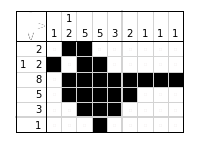

In [57]:
bird = NONOGRAM([[2], 
                 [1, 2], 
                 [8], 
                 [5], 
                 [3], 
                 [1]],
                [[1], 
                 [1, 2], 
                 [5], 
                 [5], 
                 [3], 
                 [2], 
                 [1], 
                 [1], 
                 [1]],
                 name = 'bird')

bird.solve()

In [52]:
displaySol('bird')

[Marylin Monroe](https://www.nonograms.org/nonograms/i/18521)

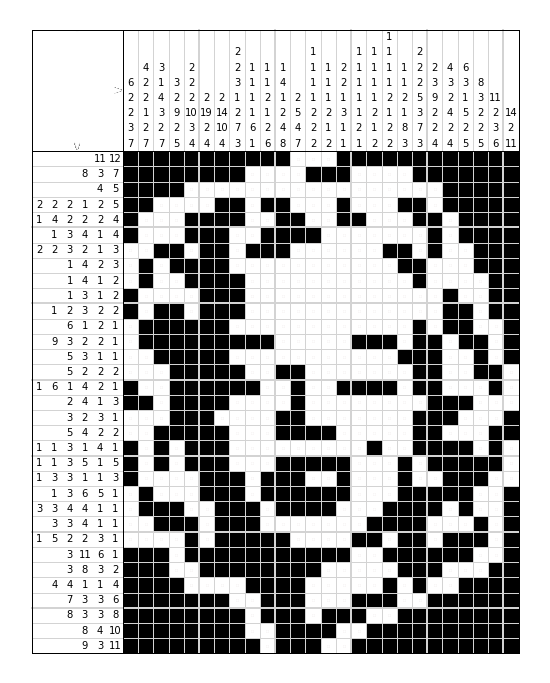

In [53]:
mM = NONOGRAM.load('MarylinMonroe')
mM.solve()

In [54]:
displaySol('MarylinMonroe')

[Dog](https://en.grandgames.net/nonograms/picross/sobaka_u70756)

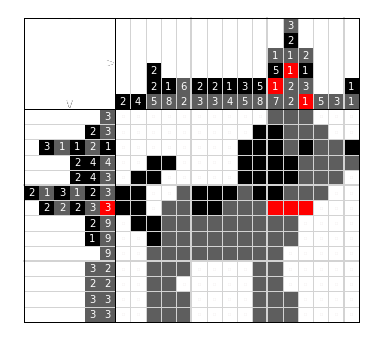

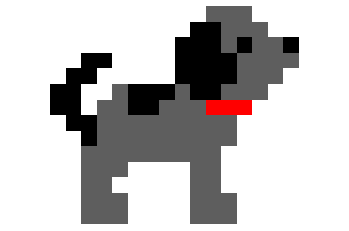

In [69]:
dog = NONOGRAM(
    [
     [(3,2)],
     [(2,1),(3,2)],
     [(3,1),(1,2),(1,1),(2,2),(1,1)],
     [(2,1),(4,1),(4,2)],
     [(2,1),(4,1),(3,2)],
     [(2,1),(1,2),(3,1),(1,2),(2,1),(3,2)],
     [(2,1),(2,2),(2,1),(3,2),(3,3)],
     [(2,1),(9,2)],
     [(1,1),(9,2)],
     [(9,2)],
     [(3,2),(2,2)],
     [(2,2),(2,2)],
     [(3,2),(3,2)],
     [(3,2),(3,2)]
    ],
    [
     [(2,1),],
     [(4,1),],
     [(2,1),(2,1),(5,2),],
     [(1,1),(8,2),],
     [(6,2),(2,2),],
     [(2,1),(3,2),],
     [(2,1),(3,2),],
     [(1,1),(4,2),],
     [(3,1),(5,2),],
     [(5,1),(8,2),],
     [(1,2),(5,1),(1,3),(7,2),],
     [(3,2),(2,1),(1,2),(1,3),(2,2),(2,2),],
     [(2,2),(1,1),(3,2),(1,3),],
     [(5,2),],
     [(3,2),],
     [(1,1),(1,2),],
    ], colors = {0 : '#FFFFFF', 1 : '#000000', 2 : '#5E5E5E', 3 : '#FF0000'}, name = 'dog'
)
    
dog.solve()    
dog.plot()

In [70]:
displaySol('dog')

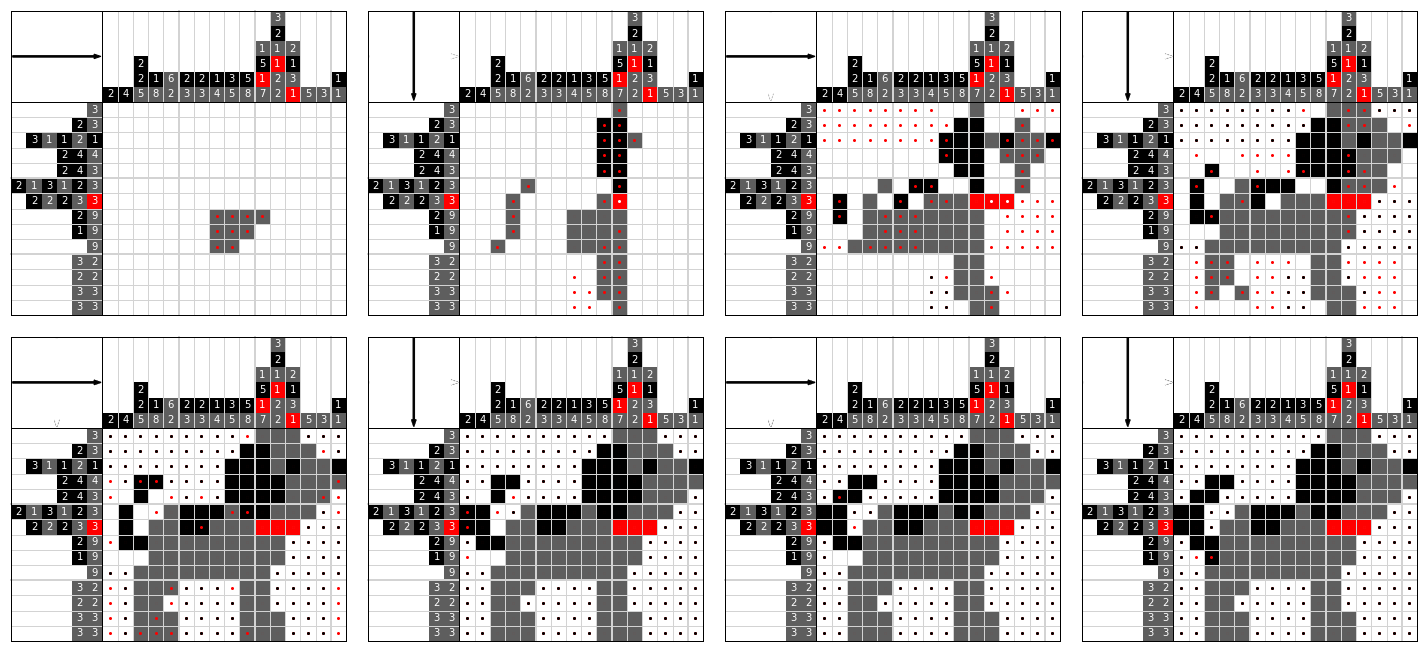

In [72]:
import PIL
displayImages.concat([PIL.Image.open(f'images/dog-{n}.png') for n in range(1,9)], nbColonnes = 4)

[Mona Lisa](https://www.nonograms.org/nonograms2/i/61537)

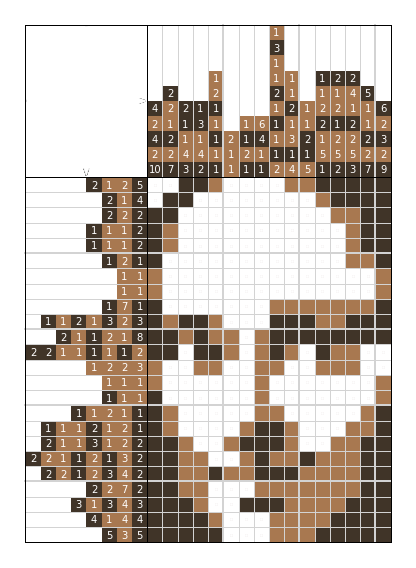

In [48]:
mL = NONOGRAM.load('MonaLisa')
mL.solve()

In [33]:
displaySol('MonaLisa')

#### Lecture d'un nonogram du site $\texttt{nonograms.org}$

Il faut installer le package $\texttt{pynogram}$ qui est un module de résolution de nonogram (beaucoup plus performant que le notre ...) et qui permet aussi de lire les nonograms de [$\texttt{nonograms.org}$](https://www.nonograms.org/), et d'autres sites d'ailleurs.
Pour cela :

$\texttt{pip install pynogram}$

La cellule suivante définit la fonction $\texttt{nonogramsOrg(}$*id*$\texttt{, }$*name*$\texttt{, colored = True}$|$\texttt{False)}$ qui renvoie le nonogram *n* situé dans le site à l'*URL* $\texttt{https://www.nonograms.org/nonograms/i/}$*id* ou  $\texttt{https://www.nonograms.org/nonograms2/i/}$*id* suivant que $\texttt{colored}$ est $\texttt{False}$
ou $\texttt{True}$.

En plus des attributs usuels de *n*, on dispose alors aussi de
*n*$\texttt{.url()}$ qui renvoie *URL*.

In [74]:
#! pip install pynogram

def nonogramsOrg(id, name, colored = False, unknown = '#0000FF'):

    from pynogram.reader import NonogramsOrg

    NonoOrg = NonogramsOrg(id, colored, 'https://www.nonograms.org/')
    solution = NonoOrg.definition()[1]

    if colored:
        cols_, lines_, _ =  NonoOrg.parse()
        colorsList = NonoOrg.definition()[0]
        numColors = dict()
        colors = {-1 : unknown, 0 : '#FFFFFF'}
        for i, color in enumerate(colorsList):
            n = i + 1
            colors[n] = '#' + color
            numColors[f'color-{n}'] = n
            if color == '000000':
                numColors['black'] = n
        lines = [[(x.size, numColors[x.color]) for x in line] for line in lines_]
        cols = [[(x.size, numColors[x.color]) for x in col] for col in cols_]
        return NONOGRAM(lines, cols, colors = colors, name = name, solution = solution, idNonogramsOrg = id)
    else:
        cols, lines = NonoOrg.parse()
        return NONOGRAM(lines, cols, name = name, solution = solution, idNonogramsOrg = id)

Par exemple

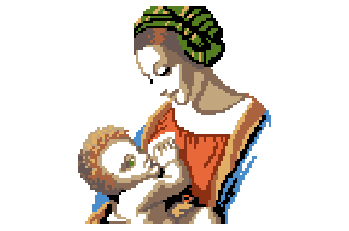

In [75]:
mLDV = nonogramsOrg('68244', 'MadonnaLittaLeonardoDaVinci', True)
mLDV.plot()

Ce nonogram n'est PAS *facile* ; ne pas exécuter $\texttt{mLDV.solve()}$, ça plante la machine.